<a href="https://colab.research.google.com/github/dkalenov/ML-Stock-Crypto-Trading/blob/3_reinforcement/PPO_AAPL_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=f3039e71170e17e9d12b5cfc42be576ea8ed725eb5db1bc71c26112aaf2de405
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [3]:
# Data Preprocessing
import pandas as pd
from pandas_datareader.data import DataReader
from ta.volume import VolumeWeightedAveragePrice

# Environment
import gym
from gym import spaces
import numpy as np
import random
import torch

# PyTorch
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

# Outputs
import matplotlib.pyplot as plt

### Data Preprocessing

In [ ]:
# # Data Extraction
# start_date = "2017-01-1"
# end_date = "2022-06-01"
# symbol = "AAPL"
# df = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
# df.drop(columns=["Adj Close"], inplace=True)
# df.head(2)

,High,Low,Open,Close,Volume
Date,,,,,
2017-01-03,29.082500,28.690001,28.950001,29.037500,115127600.0
2017-01-04,29.127501,28.937500,28.962500,29.004999,84472400.0


In [4]:
# Data Extraction
import yfinance as yf

start_date = "2017-01-1"
end_date = "2024-04-07"
symbol = "AAPL"
df = yf.download(symbol, start_date, end_date)
df.drop(columns=["Adj Close"], inplace=True) # also let's try to not drop Adj Close but use it instead of Close
df.head(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,84472400


In [5]:
# Add VWAP to DataFrame
vwap = VolumeWeightedAveragePrice(high=df["High"], low=df["Low"], close=df["Close"],
                                  volume=df["Volume"], window=14, fillna=False)
df["VWAP"] = vwap.volume_weighted_average_price()
df.dropna(inplace=True)
df.head(2)

,Open,High,Low,Close,Volume,VWAP
Date,,,,,,
2017-01-23,30.000000,30.202499,29.942499,30.0200,88200800,29.663470
2017-01-24,29.887501,30.025000,29.875000,29.9925,92844000,29.737769


In [6]:
# Min Max Scaled
df_mod = df.copy()
df_mod = df_mod.pct_change() * 100
df_mod = df_mod / df_mod.max()
df_mod = df_mod.dropna()
df_mod = df_mod.reset_index(drop=True)
df_mod["Close_Price"] = df["Close"].iloc[1:].values
df_mod.head()

,Open,High,Low,Close,Volume,VWAP,Close_Price
0,-0.038558,-0.055937,-0.022097,-0.007646,0.020029,0.132253,29.992500
1,0.074826,0.158500,0.063981,0.132884,0.150258,0.161017,30.469999
2,0.106732,0.026504,0.107573,0.004109,-0.070977,0.152441,30.485001
3,0.039719,-0.006996,0.000000,0.000684,-0.083421,0.134313,30.487499
4,-0.101862,-0.056011,-0.075773,-0.021902,0.181599,0.093867,30.407499


In [7]:
# Split Training and Testing
df_train = df_mod.copy()
df_train = df_train.iloc[:700]
df_test = df_mod.copy()
df_test = df_test.iloc[700:]

<Axes: >

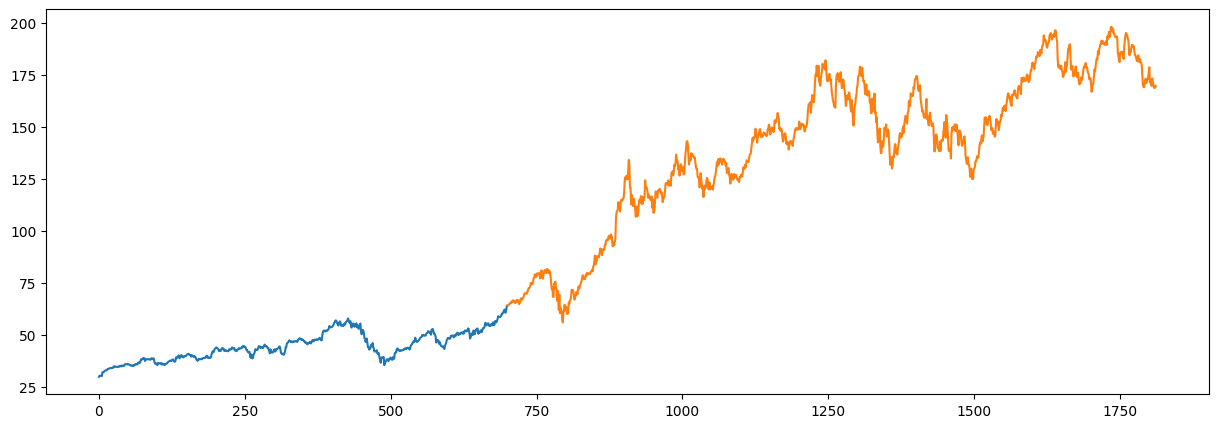

In [8]:
# View price behaviour
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
df_train["Close_Price"].plot()
df_test["Close_Price"].plot()

### Environment

In [9]:
# Initialise variables
MAX_INT = 2147483647
MAX_TRADES = 10000
MAX_OPEN_POSITIONS = 1
INITIAL_ACCOUNT_BALANCE = 1000
PERCENT_CAPITAL = 0.1
TRADING_COSTS_RATE = 0.001
KILL_THRESH = 0.4 # Threshold for balance preservation


# Structure environment
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        # Generic variables
        self.df = df

        # Account variables
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0

        # Position variables
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.long_short_ratio = 0

        # Current Step
        self.current_step = 0
        self.lag = 20
        self.volatility = 1
        self.max_steps = len(df)

        # Actions of the format Long, Hold, Close
        self.action_space = spaces.Discrete(2)

        # Prices contains the Close and Close Returns etc
        self.observation_space = spaces.Box(low=-1, high=1, shape=(7, ), dtype=np.float32)

    # Calculate Reward
    def _calculate_reward(self):
        reward = 0
        reward += self.net_profit / self.volatility
        reward += 0.01 if self.long_short_ratio >= 0.3 and self.long_short_ratio <= 0.6 else -0.01
        return reward

    # Structure sign observation data
    def _next_observation(self):

        item_0_T0 = self.df.loc[self.current_step - 0, "Open"].item()
        item_1_T0 = self.df.loc[self.current_step - 0, "High"].item()
        item_2_T0 = self.df.loc[self.current_step - 0, "Low"].item()
        item_3_T0 = self.df.loc[self.current_step - 0, "Close"].item()
        item_4_T0 = self.df.loc[self.current_step - 0, "Volume"].item()
        item_5_T0 = self.df.loc[self.current_step - 0, "VWAP"].item()

        env_4 = 1 if self.long_short_ratio else 0

        obs = np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, env_4])

        return obs

    # Set the current price to a random price within the time step
    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, "Close_Price"].item()
        next_price = self.df.loc[self.current_step + 1, "Close_Price"].item()
        next_return = next_price / current_price - 1

        # Go Long
        if action == 0:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * next_return
            self.available_balance += self.net_profit
            self.num_trades_long += 1

        # Go Short
        if action == 1:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * -next_return
            self.available_balance += self.net_profit
            self.num_trades_short += 1

        # Update metrics
        self.long_short_ratio = self.num_trades_long / (self.num_trades_long + self.num_trades_short)
        self.volatility = self.df.loc[self.current_step - self.lag, "Close_Price"].sum()

    # Execute one time step within the environment
    def step(self, action):
        self._take_action(action)

        reward = self._calculate_reward()

        self.current_step += 1

        is_max_steps_taken = self.current_step >= self.max_steps - self.lag - 1
        done = True if is_max_steps_taken else False

        obs = self._next_observation()

        return obs, reward, done, {}

    # Reset the state of the environment to an initial state
    def reset(self):
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        self.current_step = self.lag
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.num_trades_ratio = 0

        return self._next_observation()

    # Render the environment to the screen
    def render(self, mode='human', close=False):
        pass

In [10]:
# Test Environment
env = StockTradingEnv(df_train)
actions = [0,1,2]
observation = env.reset()
print("Initial Observation: ", env.reset())

for action in actions:
    obs_, reward, done, info = env.step(action)
    print("")
    print("Action Taken: ", action)
    print("Reward Received : ", reward)
    print("Next State: ", obs_)
    print("Completed: ", done)
    print("-------------------")
    print("Available Balance: ", env.available_balance)
    print("Realized Profit: ", env.net_profit)
    print("Ratio: ", env.num_trades_ratio)
    print("-------------------")

Initial Observation:  [ 0.01509509  0.02575197  0.00937149  0.02503413 -0.0569813   0.46506052
  0.        ]

Action Taken:  0
Reward Received :  -0.02410417084302246
Next State:  [ 7.15985945e-02  2.49887330e-02  1.36833751e-02 -3.53080268e-02
 -8.89242817e-04  2.47030709e-01  1.00000000e+00]
Completed:  False
-------------------
Available Balance:  999.5769806516864
Realized Profit:  -0.42301934831360244
Ratio:  0
-------------------

Action Taken:  1
Reward Received :  -0.007006886294020834
Next State:  [-0.11002195 -0.05676909 -0.07335508  0.00794776  0.01809007  0.19031721
  1.        ]
Completed:  False
-------------------
Available Balance:  999.0587808379853
Realized Profit:  -0.5181998137011128
Ratio:  0
-------------------

Action Taken:  2
Reward Received :  -0.006998517412696118
Next State:  [ 0.09305449  0.05432432  0.07245869  0.01648989 -0.02654296  0.18722969
  1.        ]
Completed:  False
-------------------
Available Balance:  999.0587808379853
Realized Profit:  -0.5

In [11]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [12]:
# CREATE A tmp DIRECTORY
import os

if not os.path.exists('tmp'):
    os.makedirs('tmp')

In [13]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo') #Original V1 has some awesome weights
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)

        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [14]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [15]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)

    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        state = state.flatten(0)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            # Calculate the advantage
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()

In [16]:
# Testing

env = StockTradingEnv(df_train)

batch_size = 5
n_epochs = 4
alpha = 0.0003

agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
                alpha=alpha, n_epochs=n_epochs,
                input_dims=env.observation_space.shape)

observation = env.reset()
action, prob, val = agent.choose_action(observation)
n_actions = env.action_space.n
print("Oberservation: ", observation)
print("Number of Actions: ", n_actions)
print("Action Chosen: ", action)
print("Probability of Action: ", prob)
print("Value of Action: ", val)

observation_, reward, done, info = env.step(action)
print("Next Oberservation", observation_)
print("Reward", reward)
print("Done", done)
print("Info", info)

Oberservation:  [ 0.01509509  0.02575197  0.00937149  0.02503413 -0.0569813   0.46506052
  0.        ]
Number of Actions:  2
Action Chosen:  1
Probability of Action:  -0.6704035997390747
Value of Action:  -0.021805347874760628
Next Oberservation [ 0.07159859  0.02498873  0.01368338 -0.03530803 -0.00088924  0.24703071
  0.        ]
Reward 0.004104170843022458
Done False
Info {}


<ipython-input-15-7f80bfeb0c52>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  state = T.tensor([observation], dtype=T.float).to(self.actor.device)


... starting ...
... saving models ...
episide: 0, score: 99.37219327164277, avg score: 99.37219327164277, best_score: 99.37219327164277
... saving models ...
episide: 1, score: 435.03675623320663, avg score: 267.2044747524247, best_score: 267.2044747524247
episide: 2, score: -2169.5897283360114, avg score: -545.0602596103873, best_score: 267.2044747524247
episide: 3, score: -10766.82942839069, avg score: -3100.502551805463, best_score: 267.2044747524247
episide: 4, score: 75.10913801496125, avg score: -2465.3802138413785, best_score: 267.2044747524247
episide: 5, score: -97.94160852928292, avg score: -2070.807112956029, best_score: 267.2044747524247
episide: 6, score: 125.12596098331817, avg score: -1757.102388107551, best_score: 267.2044747524247
episide: 7, score: -10.17215595643795, avg score: -1538.7361090886618, best_score: 267.2044747524247
episide: 8, score: -1086.89330844509, avg score: -1488.5313534615982, best_score: 267.2044747524247
episide: 9, score: -148.01046433336597, 

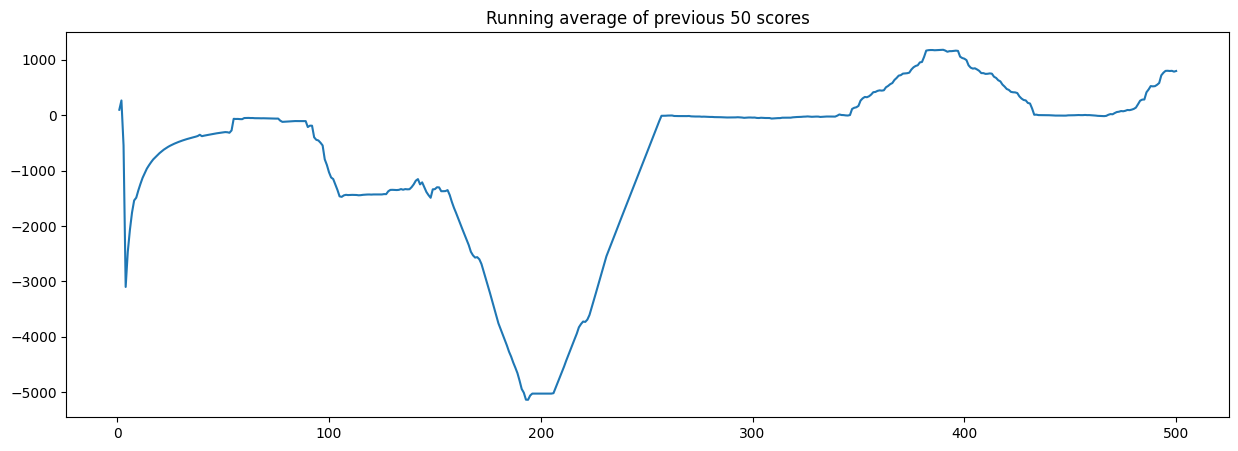

In [17]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-50):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 50 scores')
    plt.savefig(figure_file)

if __name__ == '__main__':
    env = StockTradingEnv(df_train)
    N = 20
    batch_size = 5
    n_epochs = 3
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
                    alpha=alpha, n_epochs=n_epochs,
                    input_dims=env.observation_space.shape)

    n_games = 500

    figure_file = 'stock_training.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    print("... starting ...")
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
            observation = observation_

        # Save history
        score_history.append(score)
        avg_score = np.mean(score_history[-50:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print(f"episide: {i}, score: {score}, avg score: {avg_score}, best_score: {best_score}")

    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)

### Load Model

In [18]:
# agent.save_models()
n_actions = env.action_space.n
input_dims = env.observation_space.shape
alpha = 0.0003
model = ActorNetwork(n_actions, input_dims, alpha)
model.load_state_dict(T.load("tmp/actor_torch_ppo"))
model.eval()

ActorNetwork(
  (actor): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Softmax(dim=-1)
  )
)

In [19]:
reporting_df = df_test.copy()
long_probs = []
short_probs = []
is_long = 1
is_short = 1
long_ratio = 0.5
for step in range(5, len(reporting_df)):

    item_0_T0 = df_mod.loc[step - 0, "Open"].item()
    item_1_T0 = df_mod.loc[step - 0, "High"].item()
    item_2_T0 = df_mod.loc[step - 0, "Low"].item()
    item_3_T0 = df_mod.loc[step - 0, "Close"].item()
    item_4_T0 = df_mod.loc[step - 0, "Volume"].item()
    item_5_T0 = df_mod.loc[step - 0, "VWAP"].item()

    obs = np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, long_ratio])

    state = T.tensor(obs).float()
    dist = model(state)
    probs = dist.probs.detach().numpy()

    print(np.argmax(probs), probs)

    if action == 0:
        is_long += 1
    if action == 0:
        is_short += 1
    long_ratio = is_long / (is_long + is_short)

    long_probs.append(probs[0])
    short_probs.append(probs[1])

1 [0.3648694 0.6351306]
0 [1.0000000e+00 2.6472447e-13]
0 [9.9974036e-01 2.5963609e-04]
0 [9.9925548e-01 7.4452825e-04]
0 [9.998749e-01 1.251134e-04]
0 [9.999466e-01 5.342745e-05]
0 [9.9984521e-01 1.5482034e-04]
0 [0.9942925  0.00570745]
0 [9.9975485e-01 2.4513004e-04]
0 [9.9967849e-01 3.2152113e-04]
0 [9.9945956e-01 5.4041244e-04]
0 [9.9996305e-01 3.6946094e-05]
0 [0.9983329  0.00166706]
0 [0.99425596 0.00574407]
0 [9.9985611e-01 1.4385737e-04]
0 [9.990286e-01 9.713892e-04]
0 [0.99820065 0.00179937]
1 [0.09628621 0.9037138 ]
0 [9.9983788e-01 1.6210855e-04]
0 [0.99245507 0.00754494]
0 [9.9995041e-01 4.9575392e-05]
0 [9.9987698e-01 1.2304385e-04]
0 [0.9867219  0.01327817]
0 [0.99367577 0.00632422]
0 [0.9973335  0.00266651]
0 [0.9584354  0.04156461]
1 [0.01853487 0.98146516]
0 [9.9978393e-01 2.1600726e-04]
0 [0.993404   0.00659606]
0 [0.9969212  0.00307884]
0 [0.99393255 0.00606745]
0 [9.9986130e-01 1.3872686e-04]
1 [0.00311817 0.99688184]
0 [9.9962139e-01 3.7859855e-04]
0 [0.6909758  0.

In [20]:
capital = 1
perc_invest = 1
df_res = reporting_df.copy()
df_res = df_res[["Open", "Close_Price"]]
df_res["Returns"] = df_res["Close_Price"] / df_res["Close_Price"].shift(1) - 1
df_res = df_res.iloc[5:, :]
df_res["Longs"] = long_probs
df_res["Shorts"] = short_probs
df_res.loc[df_res["Longs"] >= 0.5, "DIR"] = df_res["Longs"]
df_res.loc[df_res["Longs"] < 0.5, "DIR"] = -df_res["Shorts"]
df_res = df_res.reset_index(drop=True)

equity = capital
equities = [capital]
for index, row in df_res.iterrows():
    if index > 0:
        dir_value = df_res.loc[index - 1, "DIR"].item()
        ret_value = df_res.loc[index, "Returns"].item()
        equity = equities[index - 1] + equities[index - 1] * perc_invest * dir_value * ret_value
        equities.append(equity)

df_res["Equity"] = equities
df_res["Benchmark"] = df_res["Returns"].cumsum() + 1
df_res.head()
df_res

,Open,Close_Price,Returns,Longs,Shorts,DIR,Equity,Benchmark
0,-0.015502,65.550003,0.007919,0.364869,6.351306e-01,-0.635131,1.000000,1.007919
1,0.129373,65.489998,-0.000915,1.000000,2.647245e-13,1.000000,1.000581,1.007003
2,-0.016511,66.117500,0.009582,0.999740,2.596361e-04,0.999740,1.010169,1.016585
3,0.103164,65.660004,-0.006919,0.999255,7.445283e-04,0.999255,1.003181,1.009666
4,-0.002729,66.440002,0.011879,0.999875,1.251134e-04,0.999875,1.015089,1.021545
...,...,...,...,...,...,...,...,...
1102,-0.033525,170.029999,-0.008456,0.999810,1.896677e-04,0.999810,1.207002,2.193399
1103,-0.126733,168.839996,-0.006999,0.965744,3.425580e-02,0.965744,1.198556,2.186400
1104,-0.017636,169.649994,0.004797,0.998923,1.076831e-03,0.998923,1.204109,2.191198
1105,0.091375,168.820007,-0.004892,0.999996,4.124804e-06,0.999996,1.198224,2.186305


<Axes: >

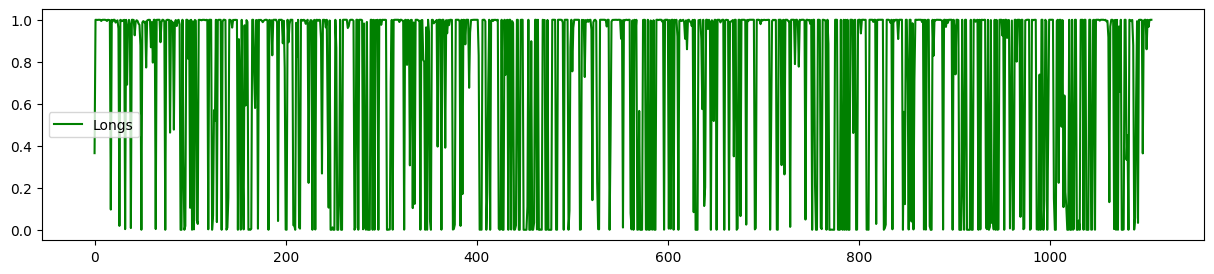

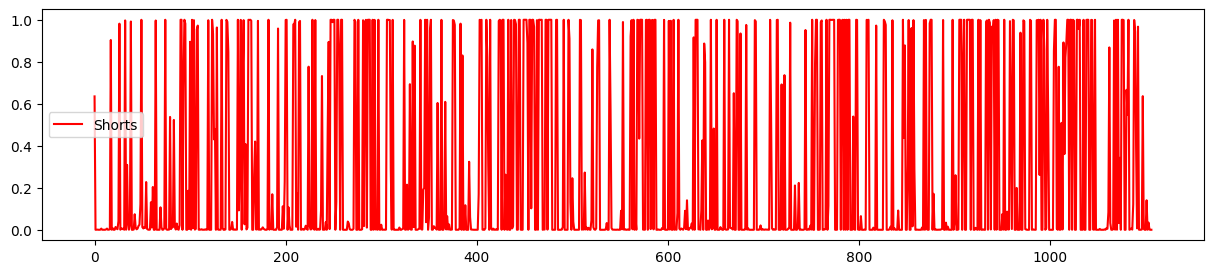

In [21]:
plt.rcParams["figure.figsize"] = (15,3)
df_res[["Longs"]].plot(color="green")
df_res[["Shorts"]].plot(color="red")

<Axes: >

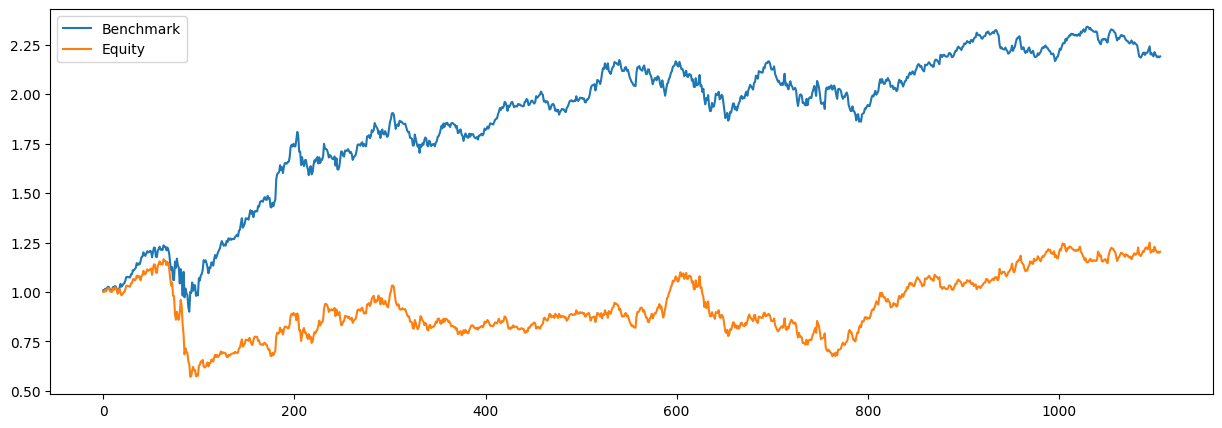

In [22]:
plt.rcParams["figure.figsize"] = (15,5)
df_res[["Benchmark", "Equity"]].plot()

In [23]:
# Metrics
Benchmark_Perc = (df_res["Close_Price"].iloc[-1] / df_res["Close_Price"].iloc[0] - 1) * 100
ROI_Perc = (df_res["Equity"].iloc[-1] / capital - 1) * 100
print(f"Benchmark Return {round(Benchmark_Perc, 2)}%")
print(f"ROI at {round(ROI_Perc, 2)}%")

Benchmark Return 158.7%
ROI at 20.36%


### Resources

PPO Code adapted from https://www.youtube.com/watch?v=hlv79rcHws0 (Machine Learning with Phil)